In [1]:
!pip install langchain-openai langchain_ollama pydantic typeddict langgraph ipython python-dotenv

  Using cached langchain_openai-1.1.9-py3-none-any.whl.metadata (3.1 kB)
  Using cached langchain_ollama-1.0.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl.metadata (90 kB)
  Using cached typeddict-0.3.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached langgraph-1.0.8-py3-none-any.whl.metadata (7.4 kB)
  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
  Using cached langchain_core-1.2.12-py3-none-any.whl.metadata (4.4 kB)
  Using cached openai-2.20.0-py3-none-any.whl.metadata (29 kB)
  Using cached tiktoken-0.12.0-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached langsmith-0.7.1-py3-none-any.whl.metadata (15 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached tenacity-9.1.4-py3-none-any.whl.metadata (1.2 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached uuid_utils-0.14.0

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + C:\gitagents26\mod6\venv\Scripts\python.exe C:\Users\Bo\AppData\Local\Temp\pip-install-nq_a7ivc\numpy_d17e1ef52c2d4a2a80df92e54cc7edaa\vendored-meson\meson\meson.py setup C:\Users\Bo\AppData\Local\Temp\pip-install-nq_a7ivc\numpy_d17e1ef52c2d4a2a80df92e54cc7edaa C:\Users\Bo\AppData\Local\Temp\pip-install-nq_a7ivc\numpy_d17e1ef52c2d4a2a80df92e54cc7edaa\.mesonpy-r1n02vre -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\Bo\AppData\Local\Temp\pip-install-nq_a7ivc\numpy_d17e1ef52c2d4a2a80df92e54cc7edaa\.mesonpy-r1n02vre\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\Bo\AppData\Local\Temp\pip-install-nq_a7ivc\numpy_d17e1ef52c2d4a2a80df92e54cc7edaa
      Build dir: C:\Users\Bo\AppData\Local\Temp\pip-install-nq_a7ivc\numpy_d17e1ef52c2d4a2a80df92e54cc7

### Prompt Chaining con Decision Gateway
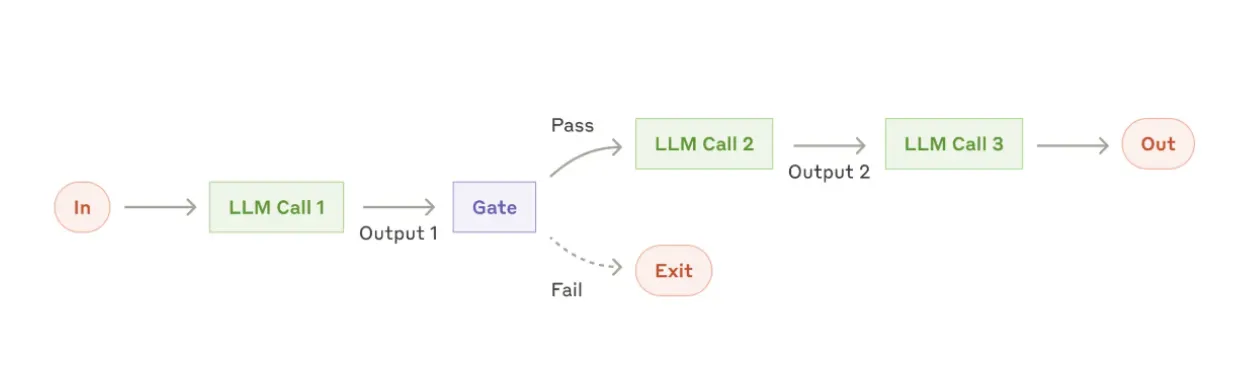

In [ ]:
from langchain_openai import ChatOpenAI # Establece la conexión con el modelo de lenguaje de OpenAI
from langchain_ollama import ChatOllama # Establece la conexión con el modelo de lenguaje de Ollama
from dotenv import load_dotenv # Cargamos variables de entorno (OpenAI Key, LangSmith Proj)
load_dotenv()
#llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
llm = ChatOllama(model="llama3.2:latest", temperature=0.2)

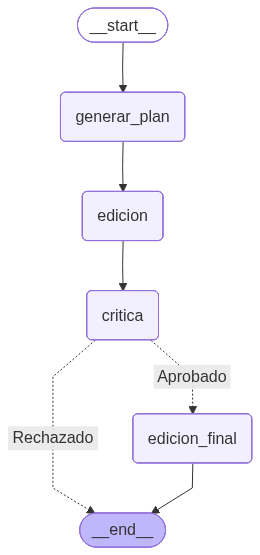

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import json

# Define el State de mi Graph para la edicion
class State(TypedDict):
    libro: str
    plan: str
    edicion: str
    critica: str
    edicion_final: str

# Contruyendo los nodos del grafo
def generar_plan(state: State):
    """Primera llamada al LLM para generar el plan de edicion"""

    msg = llm.invoke(f"""Dada la tarea de escribir un parrafo emocionante del libro {state['libro']} , 
                     debes resolver el crear un plan de ideacion que oriente su escritura""")
    return {"plan": msg.content}


def edicion(state: State):
    """Segunda invocacion al LLM que toma el plan de edicion para ya escribirlo"""
    msg = llm.invoke(f"""Ejecuta el plan de ideacion {state['plan']} al escribir el parrafo emocionante""")
    return {"edicion": msg.content}

def critica(state: State):
    """Tercera invocacion al LLM que ahora toma el rol de critico"""
    # Check simple si va asociada a la pelea con aji seco
    msg = llm.invoke(f"""Asume el rol de critico y valida si es que menciona al personaje principal del libro.
                        Finalmente, da un feedback constructivo hacia el parrafo creado.
                     Aqui el parrafo: {state["edicion"]}""")
    return {"critica": msg.content}

def validar_critica(state: State):
    """Funcion de compuerta que determina una buena o mala edicion del parrafo"""
    if "carmelo" in state["critica"].lower():
            return "Aprobado"
    return "Rechazado"


def edicion_final(state: State):
    """Cuarta invocacion a LLM que mejora el parrafo"""
    msg = llm.invoke(f"Agrega un cambio sorprendente al parrafo {state["edicion"]} en base a: {state['critica']}")
    return {"edicion_final": msg.content}


# Construye un workflow
workflow = StateGraph(State)

# Agrega nodos
workflow.add_node("generar_plan", generar_plan)
workflow.add_node("edicion", edicion)
workflow.add_node("critica", critica)
workflow.add_node("edicion_final", edicion_final)

# Conecta nodos usando vertices
workflow.add_edge(START, "generar_plan")
workflow.add_edge("generar_plan", "edicion")
workflow.add_edge("edicion", "critica")
workflow.add_conditional_edges(
    "critica", validar_critica, {"Aprobado": "edicion_final", "Rechazado": END}
)
workflow.add_edge("edicion_final", END)

# Compilar
chain = workflow.compile()

# Mostrar Workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [7]:
#Esta invocacion puede pasar un estado inicial variable.
state = chain.invoke({"libro": "Caballero Carmelo de Abraham Valdelomar"}) 

In [9]:
print("generar plan:")
print(state["plan"])
print("\n########### Edicion ###########\n")
print(state["edicion"])
print("\n########### Critica ###########n")
print(state["critica"])

if "carmelo" in state["critica"].lower():
    print("\n########### Edicion final ###########n")
    print(state["edicion_final"])
else:
    print("Parrafo rechazado! no se menciona la batalla con aji seco")

generar plan:
¡Claro! Aquí te presento un plan de idea para escribir un párrafo emocionante del libro "Caballero Carmelo" de Abraham Valdelomar:

**Título:** "La Lucha por la Justicia"

**Objetivo:** Crear un párrafo que capture la esencia de la lucha del protagonista, Carmelo, y transmita una sensación de emoción y pasión.

**Ideas clave:**

1. **Introducción**: Comienzo con una frase que establezca el tono emocional del párrafo.
2. **Desarrollo**: Describa la situación en la que se encuentra Carmelo, destacando su determinación y valentía.
3. **Climax**: Presente un momento crítico de la historia donde Carmelo enfrenta una adversidad significativa.
4. **Resolución**: Concluya el párrafo con una frase que refleje la victoria o el impacto emocional del evento.

**Estructura:**

1. Introducción (2-3 oraciones)
 * "En un mundo donde la justicia era un concepto lejano, Carmelo se levantó para luchar contra las injusticias."
2. Desarrollo (4-5 oraciones)
 * "Con una determinación que parec

### Paralelizacion
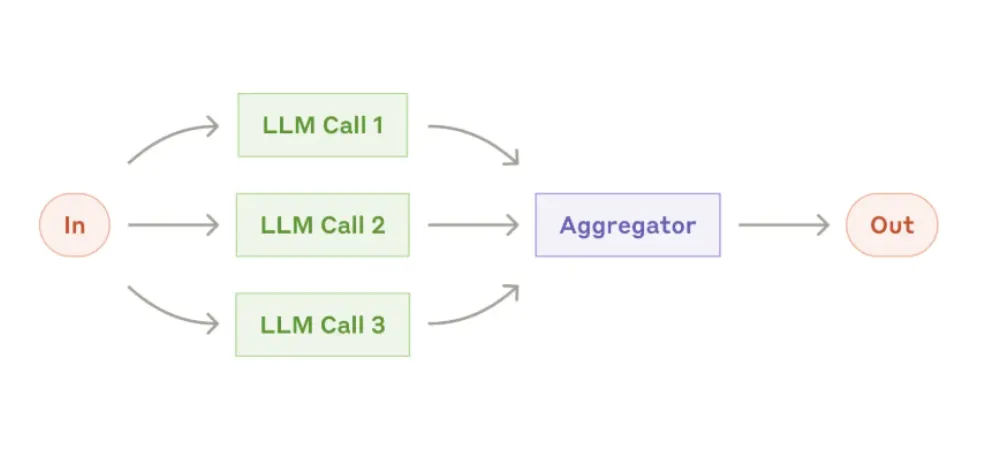

 - Util cuando tenemos mas de una perspectiva de una solucion
 - Util cuando podemos poner tareas en paralelo
 - Util cuando tenemos mas de una consulta de RAG en paralelo --> Multi query RAG


In [11]:
class State(TypedDict):
    libro: str
    animal: str
    femenino: str
    masculino: str
    composicion: str


def genera_animal(state: State):
    "Genera un nuevo personaje animal en base al libro indicado"
    msg = llm.invoke(f"Imagina un nuevo personaje que sea un animal en base al libro {state["libro"]}")
    return {"animal": msg.content}

def genera_femenino(state: State):
    "Genera un nuevo personaje humano femenino en base al libro indicado"
    msg = llm.invoke(f"Imagina un nuevo personaje humano, femenino, en base al libro {state["libro"]}")
    return {"femenino": msg.content}

def genera_masculino(state: State):
    "Genera un nuevo personaje humano masculino en base al libro indicado"
    msg = llm.invoke(f"Imagina un nuevo personaje humano, masculino, en base al libro {state["libro"]}")
    return {"masculino": msg.content}

def genera_composicion(state: State):
    msg = llm.invoke(f"""En base a estos nuevos personajes generados basados en el libro {state["libro"]},
    crea una nueva composicion de una trama con esos personajes. Aqui el detalle de cada personaje:\n
    PERSONAJE ANIMAL: {state["animal"]}\n
    PERSONAJE FEMENINO HUMANO: {state["animal"]}\n
    PERSONAJE MASCULINO HUMANO: {state["animal"]}
    """)
    return {"composicion": msg.content}


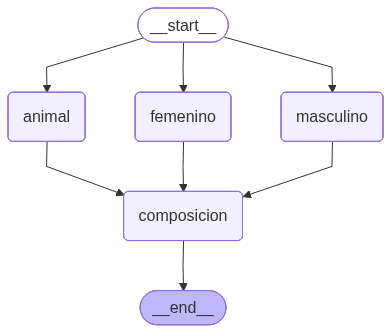

In [12]:
# Construye un workflow
parallelworkflowBuilder = StateGraph(State)

# Agrega nodos
parallelworkflowBuilder.add_node("animal", genera_animal)
parallelworkflowBuilder.add_node("femenino", genera_femenino)
parallelworkflowBuilder.add_node("masculino", genera_masculino)
parallelworkflowBuilder.add_node("composicion", genera_composicion)

# Conecta nodos usando vertices
parallelworkflowBuilder.add_edge(START, "animal")
parallelworkflowBuilder.add_edge(START, "femenino")
parallelworkflowBuilder.add_edge(START, "masculino")
parallelworkflowBuilder.add_edge("animal", "composicion")
parallelworkflowBuilder.add_edge("femenino", "composicion")
parallelworkflowBuilder.add_edge("masculino", "composicion")
parallelworkflowBuilder.add_edge("composicion", END)

# Compilar
parallelChain = parallelworkflowBuilder.compile()

# Mostrar Workflow
display(Image(parallelChain.get_graph().draw_mermaid_png()))

In [13]:
state = parallelChain.invoke({"libro":"el caballero carmelo de abraham valdelomar"})
print(state["composicion"])

¡Excelente! Me parece que has creado tres personajes interesantes basados en el libro "El Caballero Carmelo" de Abraham Valdelomar. A continuación, te propongo una posible composición de trama con estos personajes:

**Título:** La Llamada del Lobo Azul

**Sinopsis:**

En un mundo donde los humanos y los animales viven en armonía, un joven llamado Carmelo descubre que tiene el poder de transformarse en un lobo azul. El Lobo Azul es un ser mágico con una pelaje azul claro y ojos verdes brillantes, que le recuerda al traje de Carmelo.

**Personajes:**

* **Carmelo:** Un joven humano que descubre que tiene el poder de transformarse en un lobo azul. Es valiente, leal y determinado a proteger a su amada.
* **El Lobo Azul (Lobo Azul):** Un ser mágico con una pelaje azul claro y ojos verdes brillantes. Tiene la capacidad de transformarse en un ser humano y puede hablar y entender el idioma humano.
* **La Dama del Bosque:** Una figura misteriosa que vive en el bosque y tiene el poder de control

### Routing
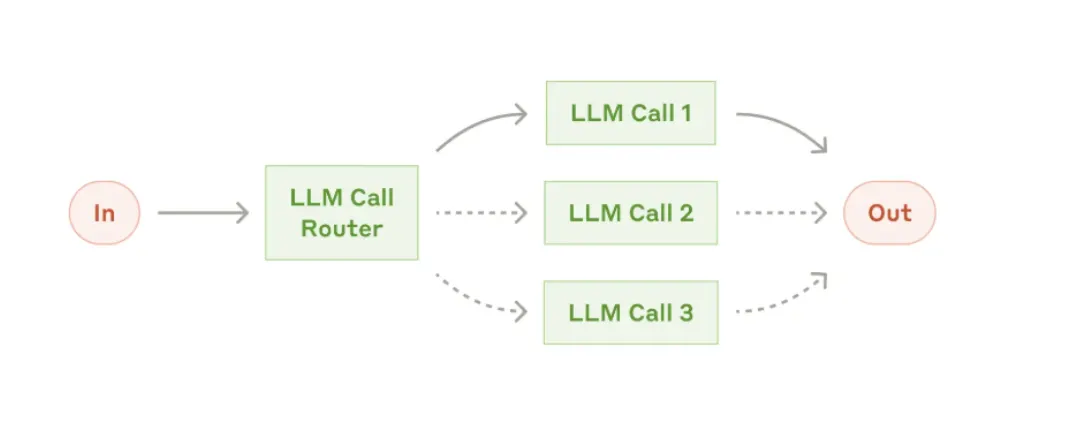
El enrutamiento clasifica una entrada y la dirige a una tarea de seguimiento especializada.

- Por ejemplo, al enrutar una pregunta a diferentes sistemas de recuperación.

Ejemplo:

- Enrutar una entrada entre chiste, cuento y poema.

In [14]:
from typing_extensions import Literal
from pydantic import BaseModel, Field

class Route(BaseModel):
    step: Literal["parrafo", "poema", "cancion"] = Field(
        None, description="El siguiente paso en el proceso de enrutamiento"
    )

router = llm.with_structured_output(Route)

In [15]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage

def genera_parrafo(state: State):
    """Escribe un parrafo creativo"""
    print("Escribe un parrafo creativo")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def genera_poema(state: State):
    """Escribe un poema"""
    print("Escribe un poema")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def genera_cancion(state: State):
    """Escribe la letra de una cancion"""
    print("Escribe la letra de una cancion")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def enrutador(state: State):
    """Enrutar el input hacia el nodo apropiado"""
    # correr el LLM con salida estructurada para enrutar la atencion
    decision = router.invoke(
        [
            SystemMessage(
                content="Enruta el input del usuario hacia crear un parrafo, poema, o cancion conforme lo pida el usuario."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "parrafo":
        return "genera_parrafo"
    elif state["decision"] == "poema":
        return "genera_poema"
    elif state["decision"] == "cancion":
        return "genera_cancion"

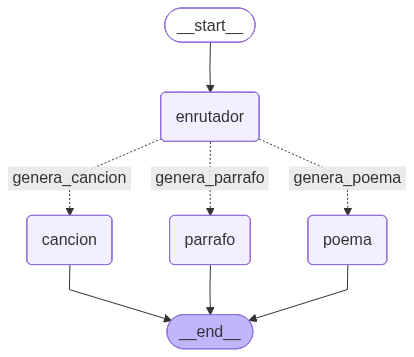

In [17]:
#workflow
routerWorkflowBuilder = StateGraph(State)

# Add nodes
routerWorkflowBuilder.add_node("parrafo", genera_parrafo)
routerWorkflowBuilder.add_node("poema", genera_poema)
routerWorkflowBuilder.add_node("cancion", genera_cancion)
routerWorkflowBuilder.add_node("enrutador", enrutador)

# Add edges to connect nodes
routerWorkflowBuilder.add_edge(START, "enrutador")
routerWorkflowBuilder.add_conditional_edges(
    "enrutador",
    route_decision,
    {  # Nombre obtenido por route_decision : Nombre del nodo a visitar
        "genera_parrafo": "parrafo",
        "genera_poema": "poema",
        "genera_cancion": "cancion",
    },
)
routerWorkflowBuilder.add_edge("parrafo", END)
routerWorkflowBuilder.add_edge("poema", END)
routerWorkflowBuilder.add_edge("cancion", END)

# Compile workflow
router_workflow = routerWorkflowBuilder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [18]:
state = router_workflow.invoke({"input": "escribe una cancion sobre el caballero carmelo"})
print(state["output"])

Escribe la letra de una cancion
¡Claro! Aquí te dejo una canción inspirada en el Caballero Carmelo:

**Título:** "El Caballero del Sol"

**Verso 1:**
En un valle lejano, donde el sol se pone,
Había un caballero, con un corazón de oro.
Se llamaba Carmelo, y su espada era larga,
Luchó por la justicia, sin temor a nada.

**Coro:**
Carmelo, Carmelo, caballero del sol,
Con tu espada brillante, siempre estás en el camino.
Por la tierra y el mar, has luchado con valor,
Un héroe de la leyenda, para siempre vivirá.

**Verso 2:**
Con su caballo blanco, y su armadura plateada,
Carmelo se adentró, en un mundo lleno de peligro.
Luchó contra el mal, y defendió a los inocentes,
Su honor y su corazón, nunca cedieron.

**Coro:**
Carmelo, Carmelo, caballero del sol,
Con tu espada brillante, siempre estás en el camino.
Por la tierra y el mar, has luchado con valor,
Un héroe de la leyenda, para siempre vivirá.

**Puente:**
En un día de batalla, cuando todo parecía perdido,
Carmelo se levantó, y su espada 

### Orquestador
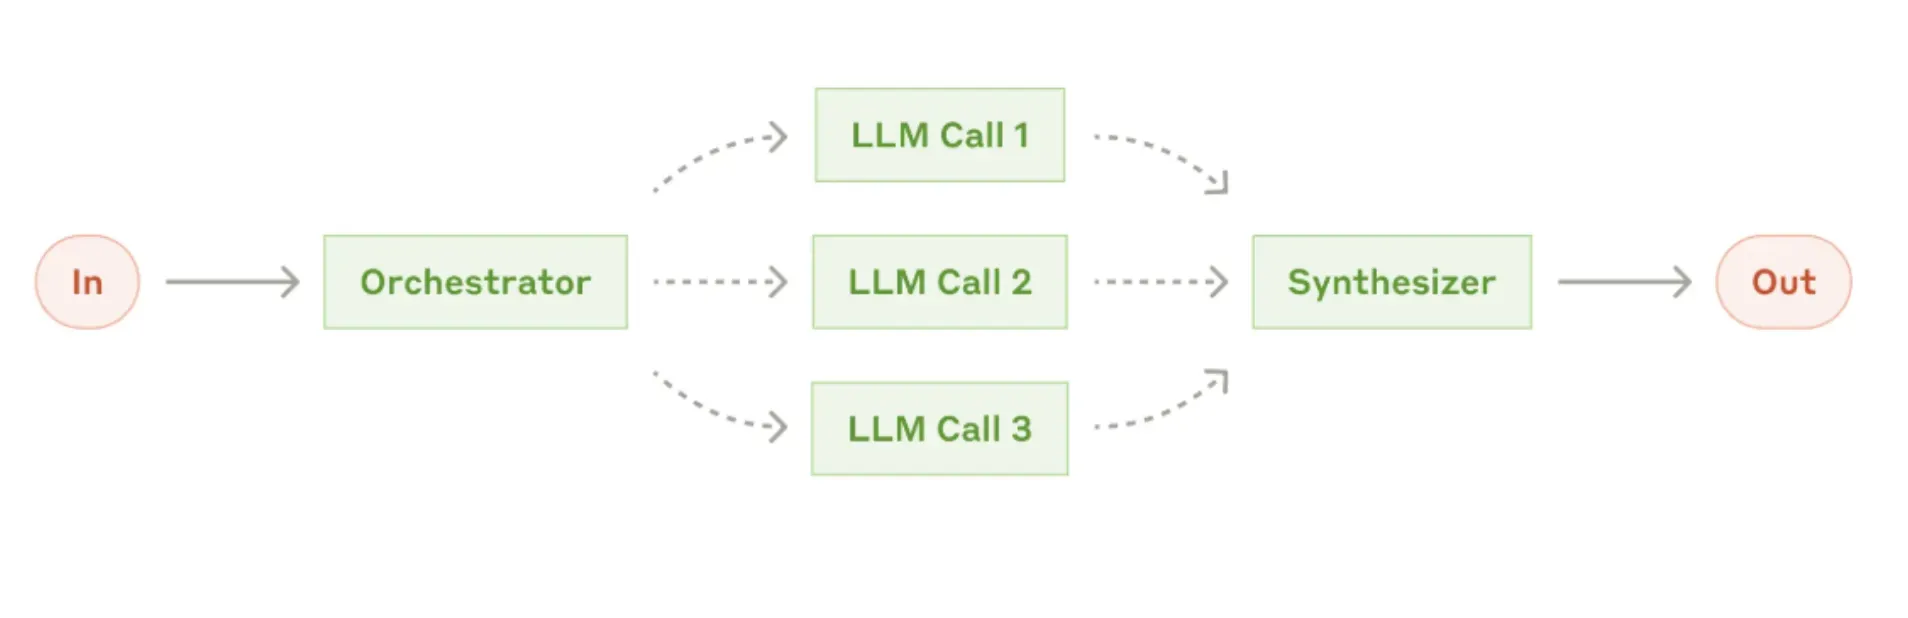
El orquestador desglosa una tarea y delega cada subtarea a los trabajadores.

- Por ejemplo, planificar un informe donde LLM puede determinar el número de secciones.

Ejemplo:

- Tomar un tema, planificar un informe por secciones y pedir a cada trabajador que escriba una sección.

In [19]:
from typing import Annotated, List
import operator

# Establecemos una estructura para la generacion de secciones del reporte
class Section(BaseModel):
    name: str = Field(
        description="Nombre de la seccion del reporte.",
    )
    description: str = Field(
        description="Una descripcion basica de temas y conceptos a ser cubiertos en esta seccion.",
    )

# Establecemos que un compendio se secciones es input para un reporte
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Secciones del reporte.",
    )

# LLM con structured output
planner = llm.with_structured_output(Sections)

In [20]:
# Graph state> administra el estado general recibido por el orquestador
class State(TypedDict):
    topic: str  # tema del reporte
    sections: list[Section]  # lista de secciones del reporte
    completed_sections: Annotated[
        list, operator.add
    ]  # todos los workers pueden ver y escribir a este item en paralelo
    final_report: str  # reporte final

# Worker state> administra estados internos de cada worker
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [21]:
from langgraph.constants import Send
# Nodos
def orchestrator(state: State):
    """Orquestador que genera el plan de elaboracion del reporte"""
    # Genera las peticiones de elaboracion de secciones en base a su plan
    report_sections = planner.invoke(
        [
            SystemMessage(content="Genera un plan para elaborar el reporte."),
            HumanMessage(content=f"Aqui el tema del reporte: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}


def worker(state: WorkerState):
    """Worker que escribe una seccion del reporte"""
    # Genera seccion objetivo
    section = llm.invoke(
        [
            SystemMessage(content="Escribe una seccion del reporte."),
            HumanMessage(
                content=f"Aqui esta el nombre de la seccion: {state['section'].name} y su descripcion: {state['section'].description}"
            ),
        ]
    )
    # Escribe el contenido de la seccion lograda en el item de estado de orquestador
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Sintetiza el reporte completo en base a las secciones"""
    # Lista de secciones completadas
    completed_sections = state["completed_sections"]
    # Fomartear seccion completada a str para usarla como contect para secciones finales
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

# Condicional para crear workers por cada seccion del reporte
def assign_workers(state: State):
    """Asigna un worker a cada seccion en el plan"""
    # Ejecutamos la escritura en paralelo de workers en paralelo via Send() API
    return [Send("workers", {"section": s}) for s in state["sections"]]

C:\Users\Bo\AppData\Local\Temp\ipykernel_8596\4163848350.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


C:\Users\Bo\AppData\Local\Temp\ipykernel_8596\120190386.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


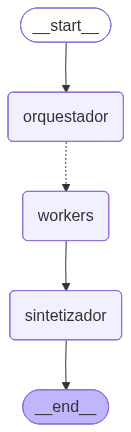

In [22]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orquestador", orchestrator)
orchestrator_worker_builder.add_node("workers", worker)
orchestrator_worker_builder.add_node("sintetizador", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orquestador")
orchestrator_worker_builder.add_conditional_edges(
    "orquestador", assign_workers, ["workers"]
)
orchestrator_worker_builder.add_edge("workers", "sintetizador")
orchestrator_worker_builder.add_edge("sintetizador", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [23]:
state = orchestrator_worker.invoke({"topic": "Crea un reporte sobre reglas de escalabilidad de LLMs"})
from IPython.display import Markdown

Markdown(state["final_report"])

**Introducción**

El presente informe tiene como objetivo proporcionar una visión general de las tendencias y desafíos actuales en el campo de [insertar área de estudio o tema], con el fin de ofrecer recomendaciones estratégicas para abordarlos de manera efectiva. El informe se centra en la [insertar propósito principal del informe, por ejemplo: "análisis de las oportunidades y desafíos en la implementación de tecnologías emergentes" o "evaluación de la situación actual en el sector público"].

**Propósito del Informe**

El objetivo principal de este informe es:

* Proporcionar una visión general de las tendencias y desafíos actuales en [insertar área de estudio o tema]
* Identificar oportunidades y desafíos clave para abordarlos de manera efectiva
* Ofrecer recomendaciones estratégicas para mejorar la eficiencia y el rendimiento en [insertar área de estudio o tema]

**Estructura del Informe**

El informe está estructurado en las siguientes secciones:

1. Introducción (la sección que estamos creando ahora)
2. Análisis de tendencias y desafíos
3. Oportunidades y desafíos clave
4. Recomendaciones estratégicas
5. Conclusión

**Antecedentes**

[Insertar información relevante sobre el contexto y la historia del tema, si es necesario]

Espero que esto te sea útil. ¿Quieres agregar algo más o cambiar algo?

---

**Reglas de escalabilidad de LLMs**

La escalabilidad de los modelos de lenguaje grandes (LLMs) es un tema crucial en el desarrollo de estos modelos, ya que su capacidad para procesar y entender grandes cantidades de texto puede ser limitada por la cantidad de recursos disponibles. A continuación, se presentan algunas reglas clave para garantizar la escalabilidad de los LLMs:

**1. Diseño modular**

Los diseños modulares permiten a los desarrolladores agregar o eliminar componentes del modelo sin afectar su funcionamiento general. Esto permite una mayor flexibilidad y escalabilidad en el uso de recursos.

**2. Utilización de tecnologías de procesamiento paralelo**

Las tecnologías de procesamiento paralelo, como las GPU y las núcleos multi-procesador, permiten a los LLMs procesar grandes cantidades de texto simultáneamente, lo que aumenta su velocidad y eficiencia.

**3. Optimización de la carga de datos**

La optimización de la carga de datos es crucial para garantizar que el modelo pueda procesar grandes cantidades de texto sin sobrecargar los recursos del sistema. Esto puede lograrse mediante técnicas como la compresión de datos y la utilización de algoritmos de aprendizaje eficientes.

**4. Utilización de técnicas de aprendizaje en paralelo**

Las técnicas de aprendizaje en paralelo, como el entrenamiento en paralelo y el uso de bloques de trabajo, permiten a los LLMs aprender de grandes cantidades de datos simultáneamente, lo que aumenta su capacidad para procesar texto.

**5. Implementación de sistemas de gestión de recursos**

Los sistemas de gestión de recursos, como los algoritmos de asignación de recursos y las técnicas de escalabilidad, permiten a los LLMs gestionar eficientemente sus recursos y garantizar que se utilicen de manera óptima.

**6. Utilización de modelos más pequeños**

La utilización de modelos más pequeños puede ser una forma efectiva de aumentar la escalabilidad de un LLM. Los modelos más pequeños requieren menos recursos computacionales y pueden procesar texto de manera más rápida y eficiente.

**7. Optimización del uso de memoria**

La optimización del uso de memoria es crucial para garantizar que el modelo pueda procesar grandes cantidades de texto sin sobrecargar la memoria del sistema. Esto puede lograrse mediante técnicas como la compresión de datos y la utilización de algoritmos de aprendizaje eficientes.

**8. Implementación de sistemas de monitoreo**

Los sistemas de monitoreo permiten a los desarrolladores supervisar el rendimiento del modelo en tiempo real y tomar medidas para optimizar su escalabilidad y rendimiento.

En resumen, la escalabilidad de los LLMs requiere una combinación de técnicas y estrategias para garantizar que se utilicen de manera óptima los recursos computacionales y de memoria. Al seguir estas reglas, los desarrolladores pueden crear modelos más escalables y eficientes que puedan procesar grandes cantidades de texto con facilidad.

---

**Estrategias de escalabilidad y su descripción**

La escalabilidad es un aspecto crítico en el desarrollo de modelos de lenguaje, ya que puede afectar significativamente la precisión y la eficiencia del modelo. En este sentido, las estrategias de escalabilidad son fundamentales para garantizar que los modelos de lenguaje puedan manejar grandes cantidades de datos y realizar tareas complejas con precisión.

**Estrategias de escalabilidad**

Existen varias estrategias que se pueden utilizar para mejorar la escalabilidad de los modelos de lenguaje. A continuación, se presentan algunas de las más comunes:

1. **Aprendizaje en paralelo**: Este enfoque permite entrenar múltiples copias del modelo simultáneamente, lo que puede acelerar significativamente el proceso de aprendizaje.
2. **Distribución de datos**: La distribución de los datos entre varios servidores o nodos puede ayudar a mejorar la escalabilidad al permitir que cada nodo se encargue de un conjunto específico de datos.
3. **Uso de técnicas de procesamiento paralelo**: Técnicas como el procesamiento paralelo en GPU, TPUs y otros recursos de procesamiento pueden ser utilizadas para acelerar la ejecución del modelo.
4. **Optimización de la arquitectura del modelo**: La optimización de la arquitectura del modelo puede ayudar a reducir la complejidad y mejorar la escalabilidad.
5. **Uso de técnicas de aprendizaje en línea**: Las técnicas de aprendizaje en línea pueden ser utilizadas para entrenar el modelo de manera incremental, lo que puede ayudar a mejorar la escalabilidad al permitir que el modelo se adapte a nuevos datos sin necesidad de reencontrar el equilibrio.
6. **Uso de técnicas de transferencia de conocimiento**: Las técnicas de transferencia de conocimiento pueden ser utilizadas para aprovechar las características del modelo existente y adaptarlo a nuevos tareas y datos.

**Técnicas de escalabilidad**

Además de las estrategias mencionadas anteriormente, hay varias técnicas específicas que se pueden utilizar para mejorar la escalabilidad de los modelos de lenguaje. Algunas de estas técnicas incluyen:

1. **Uso de técnicas de aprendizaje por retropropagación**: La retropropagación es un algoritmo utilizado en el entrenamiento de redes neuronales que puede ayudar a mejorar la escalabilidad.
2. **Uso de técnicas de optimización**: Las técnicas de optimización, como gradient descent y Adam, pueden ser utilizadas para mejorar la escalabilidad del modelo.
3. **Uso de técnicas de regularización**: La regularización es una técnica que se utiliza para prevenir el sobreajuste del modelo y mejorar su escalabilidad.

En resumen, las estrategias y técnicas de escalabilidad son fundamentales para garantizar que los modelos de lenguaje puedan manejar grandes cantidades de datos y realizar tareas complejas con precisión. Al utilizar estas estrategias y técnicas, se puede mejorar la escalabilidad del modelo y alcanzar mejores resultados en las aplicaciones de lenguaje natural.

---

**Desafíos y Limitaciones**

En este capítulo, se analizarán los desafíos y limitaciones que enfrentan las reglas de escalabilidad en modelos de lenguaje grandes (LLMs). Estos desafíos son fundamentales para comprender el potencial y la vulnerabilidad de estas tecnologías.

**1. Escalabilidad de la Memoria**

Una de las principales limitaciones de las reglas de escalabilidad en LLMs es su capacidad para manejar grandes cantidades de memoria. A medida que aumenta la cantidad de datos que se procesan, el modelo requiere más memoria para almacenar y acceder a los datos. Esto puede ser un desafío en entornos con recursos limitados o cuando se necesitan procesar grandes cantidades de datos.

**2. Complexidad del Modelo**

Los modelos de lenguaje grandes son complejos y requieren una gran cantidad de entrenamiento para alcanzar niveles de precisión altos. Sin embargo, esta complejidad también puede generar desafíos en la escalabilidad. Los modelos pueden requerir más recursos computacionales y memoria para ejecutarse, lo que puede ser un obstáculo para entornos con recursos limitados.

**3. Dificultad para Adaptar a Nuevas Reglas**

Las reglas de escalabilidad en LLMs están diseñadas para adaptarse a nuevas reglas y patrones en el lenguaje. Sin embargo, esta capacidad también puede ser un desafío. Los modelos pueden requerir grandes cantidades de entrenamiento y ajuste para adaptarse a nuevas reglas, lo que puede ser un proceso lento y costoso.

**4. Riesgo de Overfitting**

Los modelos de lenguaje grandes están propensos al overfitting, es decir, a la tendencia a memorizar los datos de entrenamiento en lugar de aprender patrones más generales. Esto puede generar desafíos en la escalabilidad, ya que el modelo puede requerir ajustes y ajustes para evitar este problema.

**5. Dependencia de los Dados**

Las reglas de escalabilidad en LLMs están profundamente arraigadas en los datos de entrenamiento. Sin embargo, esta dependencia también puede ser un desafío. Los modelos pueden requerir grandes cantidades de datos para alcanzar niveles de precisión altos, lo que puede ser un obstáculo para entornos con recursos limitados o cuando se necesitan procesar grandes cantidades de datos.

En resumen, las reglas de escalabilidad en LLMs enfrentan varios desafíos y limitaciones, incluyendo la escalabilidad de la memoria, la complejidad del modelo, la dificultad para adaptarse a nuevas reglas, el riesgo de overfitting y la dependencia de los datos. Estos desafíos son fundamentales para comprender el potencial y la vulnerabilidad de estas tecnologías.

---

**Conclusión**

En este informe, hemos presentado una visión detallada de las tendencias y desafíos actuales en [tema o industria específica]. A través de análisis y estadísticas, hemos identificado oportunidades para mejorar la eficiencia y reducir los riesgos en [área específica].

**Resumen de los puntos clave del informe**

A continuación, se presentan los puntos clave del informe:

*   **Tendencias actuales**: [Breve descripción de las tendencias actuales en el tema o industria específica]
*   **Desafíos y riesgos**: [Descripción detallada de los desafíos y riesgos identificados en el informe]
*   **Oportunidades para mejora**: [Análisis de las oportunidades para mejorar la eficiencia y reducir los riesgos en la área específica]
*   **Consejos y recomendaciones**: [Sugerencias prácticas para implementar cambios positivos en la organización o industria]

**Recomendaciones futuras**

En el futuro, es importante seguir monitoreando las tendencias y desafíos identificados en este informe. También se recomienda:

*   **Investigación adicional**: [Sugerencia de investigar temas relacionados con los puntos clave del informe]
*   **Implementación de cambios**: [Recomendación de implementar cambios positivos en la organización o industria]

**Conclusiones finales**

En resumen, este informe proporciona una visión clara de las tendencias y desafíos actuales en [tema o industria específica]. Con base en el análisis realizado, se identifican oportunidades para mejorar la eficiencia y reducir los riesgos. Se recomienda seguir monitoreando las tendencias y desafíos identificados y implementar cambios positivos en la organización o industria.

### Evaluator-optimizer
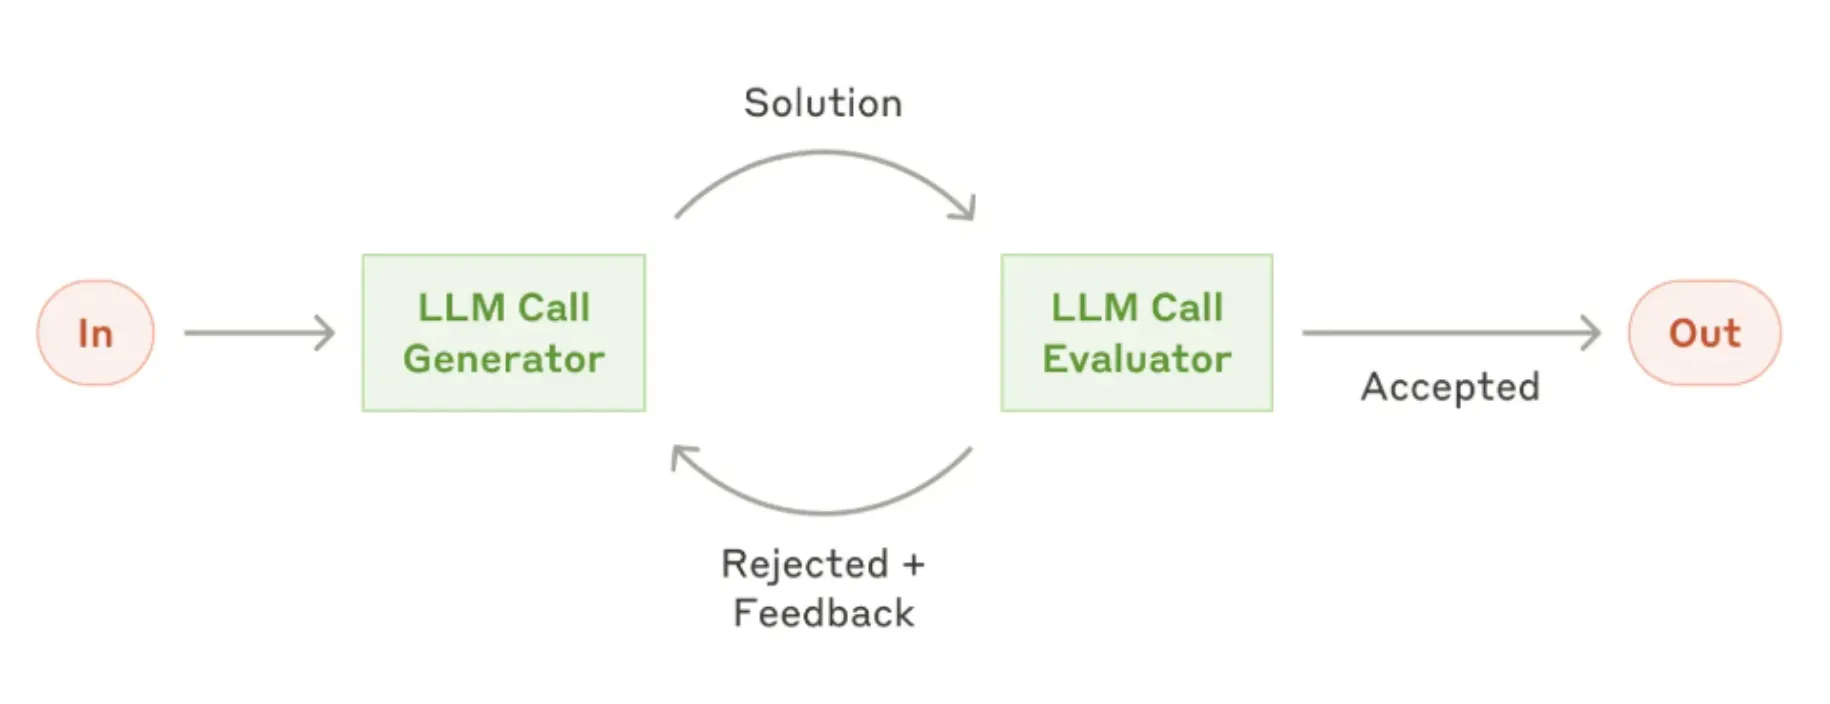
Una llamada LLM genera una respuesta, mientras que otra proporciona evaluación y retroalimentación en un bucle.

Por ejemplo, al evaluar la calidad de las respuestas de un sistema RAG (para alucinaciones).

In [24]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide si una broma es graciosa o no.",
    )
    feedback: str = Field(
        description="Si es que no es graciosa, da feedback en como mejorarla.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [25]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [26]:
# Nodes
def llm_call_generator(state: State):
    """Genera una broma"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Escribe una broma sobre {state['topic']} pero considera el feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Escribe una broma sobre {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """Evalua una broma generada"""
    grade = evaluator.invoke(f"Evalua la siguiente broma> {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Retorna hacia el generador de bromas o termina basado en feedback del evaluador"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

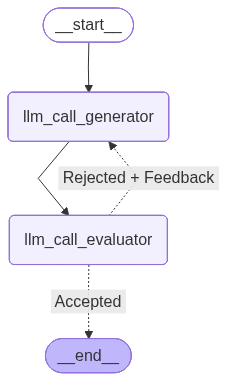

In [27]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [28]:
state = optimizer_workflow.invoke({"topic": "llms en un bar"})
print(state["joke"])

¡Claro! Aquí te dejo una broma sobre LLMs en un bar que intenta ser más original y divertida:

Un cliente entra en el bar y se sienta en la mesa del bartender. El bartender le pregunta: "¿Qué puede yo hacer por usted hoy?"

El cliente responde: "Quiero saber si puedo confiar en su modelo de lenguaje para generar textos inteligentes."

El bartender sonríe y dice: "Bueno, tengo entrenado a mi modelo para tomar decisiones... como decidir qué cerveza es la mejor para usted. Pero para tu pregunta, voy a tener que consultar con mi modelo de lenguaje para generar un texto inteligente..."

Luego, el bartender se vuelve hacia su teléfono y comienza a hablar con su modelo de lenguaje: "¿Cuál es el mejor tipo de cerveza para este cliente?"

El modelo de lenguaje responde: "La cerveza más adecuada sería una IPA con un toque de citrus, pero si prefiere algo más tradicional, podría optar por una pilsner con un toque de amargor."

El bartender se vuelve hacia el cliente y dice: "Bueno, parece que mi 

In [29]:
print(state["feedback"])

Excelente broma! Me parece muy divertida y creativa la forma en que el bartender utiliza su modelo de lenguaje para tomar una decisión sobre la cerveza para el cliente. La interacción entre el bartender y el modelo de lenguaje es muy natural y divertida, y la forma en que el modelo de lenguaje proporciona diferentes opciones al bartender es muy realista. Sin embargo, podría haber un poco más de humor y sátira en la broma, ya que la situación se desarrolla un poco lentamente. En general, sin embargo, me parece una excelente broma que hace referencia a los modelos de lenguaje y su capacidad para tomar decisiones.


In [30]:
print(state["funny_or_not"])

funny


### Agent
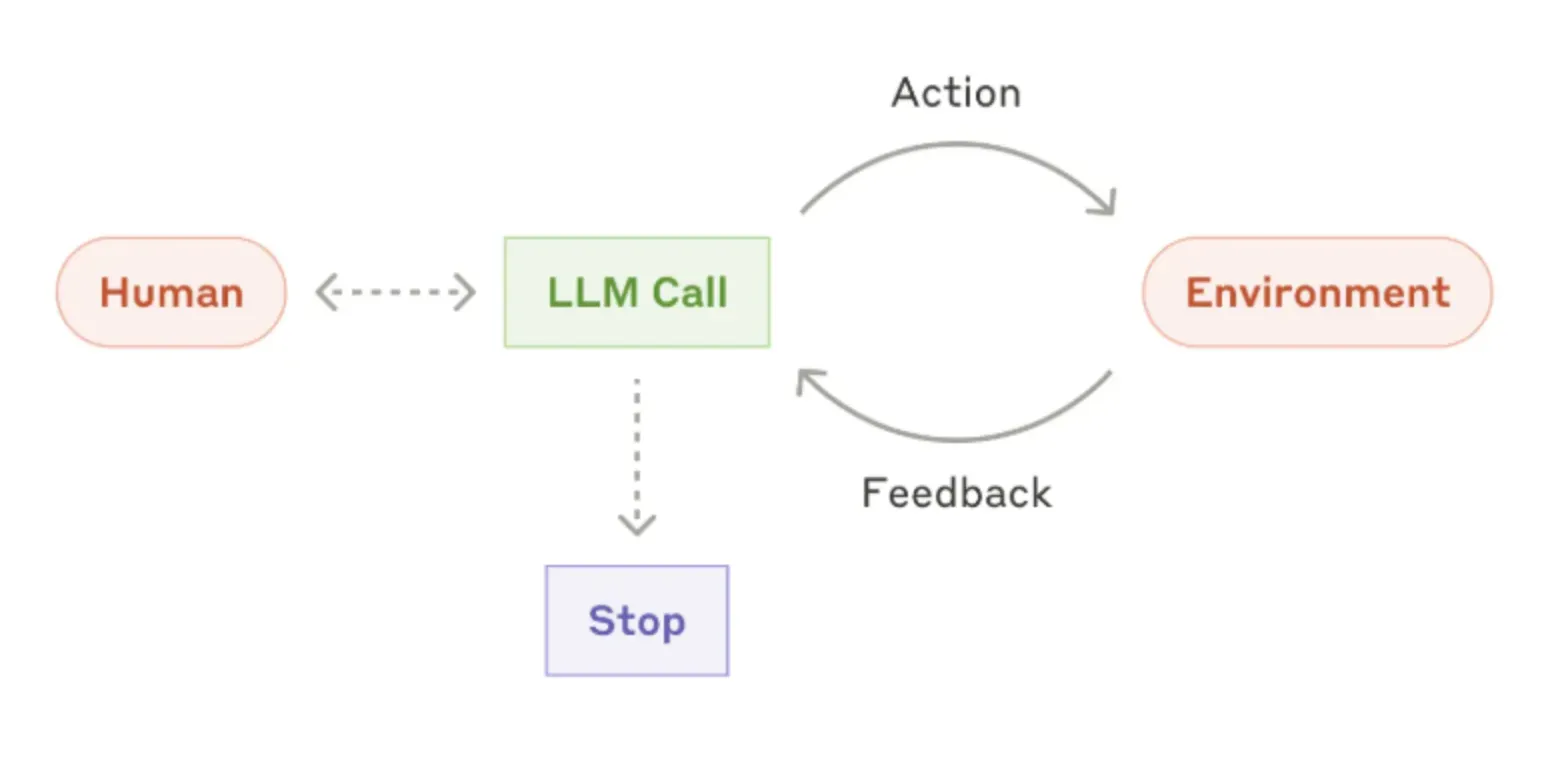
Los agentes planifican, toman medidas (mediante la llamada a herramientas) y responden a la retroalimentación (en un bucle).

Por ejemplo, al resolver problemas abiertos que no se pueden definir como un flujo de trabajo.

In [31]:
from langchain_core.tools import tool

@tool
def multiplicar(a: int, b: int) -> int:
    """multiplicar a * b.
    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def sumar(a: int, b: int) -> int:
    """sumar a + b.
    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def dividir(a: int, b: int) -> float:
    """Dividir a / b.
    Args:
        a: first int
        b: second int
    """
    return a / b

@tool
def substraer(a: int, b: int) -> int:
    """Dividir a - b.
    Args:
        a: first int
        b: second int
    """
    return a - b


# Augment the LLM with tools
tools = [sumar, multiplicar, dividir, substraer]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [32]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage

# nodos del agente en langgraph
def llm_call(state: MessagesState):
    """LLM decide si invocar a herramienta o no"""
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="Eres un asistente útil encargado de realizar cálculos aritméticos en un conjunto de entradas."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Ejecuta la invocacion a una herramienta"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Función Condicional para enrutar al nodo de TOOL o al estado END según resultado
# Solamente puede devolver uno de estos dos valores, environment o END. 
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

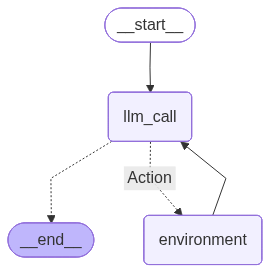

In [33]:
# workflow
agent_builder = StateGraph(MessagesState)

# Agrega nodos
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Agrega vertices para conectar nodos
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Nombre retornado por "should_continue" : Nombre del nodo a visitar
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compilar agent
agent = agent_builder.compile()

# Mostrar Agente
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [34]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================
Tool Calls:
  sumar (a51910d5-b51a-474e-8ffc-46c27fa91294)
 Call ID: a51910d5-b51a-474e-8ffc-46c27fa91294
  Args:
    a: 3
    b: 4
  multiplicar (245847a6-b3bc-4840-bf6a-1c0dd48196fa)
 Call ID: 245847a6-b3bc-4840-bf6a-1c0dd48196fa
  Args:
    a: 12
    b: 4
================================= Tool Message =================================

7
================================= Tool Message =================================

48
================================== Ai Message ==================================

La respuesta al usuario es: La suma de 3 y 4 es 7. El resultado multiplicado por 4 es 48.
